[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ManuelEspejo/NLP-Sentiment-Analysis-Mental-Health/blob/main/text-classification-with-neural-networks.ipynb)

## Index
* [Imports](#Imports)
* [Loading data](#Loading-data)
* [Exploring data](#Exploring-data)
* [Split data](#Split-data)
	* [Split into subsets](#Split-into-subsets)
	* [Split into features and labels](#Split-into-features-and-labels)
* [Data visualizations](#Data-visualizations)
* [Baseline](#Baseline)
	* [Results Baseline](#Results-Baseline)
* [Text vectorizer](#Text-vectorizer)
	* [Exploration for vectorizer](#Exploration-for-vectorizer)
	* [Creating vectorizer layer](#Creating-vectorizer-layer)
		* [Checking how the vectorizer works](#Checking-how-the-vectorizer-works)
* [Word embeddings](#Word-embeddings)
* [Creating datasets for the models](#Creating-datasets-for-the-models)
* [Dense model](#Dense-model)
	* [Results](#Results-Dense)
* [LSTM model](#LSTM-model)
	* [Results](#Results-LSTM)
* [Conv1D model](#Conv1D-model)
	* [Results](#Results-Conv1D)
* [Final visualizations](#Final-visualizations)
    * [Comparing results](#Comparing-results)
    * [Confusion matrices](#Confusion-matrices)
* [Evaluating model on test set](#Evaluating-model-on-test-set)
* [Worst predictions (test set)](#Worst-predictions-(test-set))

    
     

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile

import random

from sklearn.model_selection import train_test_split
from sklearn import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             confusion_matrix,
                             ConfusionMatrixDisplay)

from keras.utils import plot_model
from keras import Model
from keras.layers import (Conv1D,
                          Dense,
                          Dropout,
                          Embedding,
                          Flatten,
                          GlobalMaxPooling1D,
                          Input,
                          LSTM,
                          TextVectorization)

In [3]:
print(tf.__version__)

2.10.0


# Checking GPU

In [4]:
!nvidia-smi

Tue Jun 27 20:15:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0  On |                  N/A |
| 38%   40C    P8    N/A /  85W |    476MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading data

In [8]:
# Extracting zip file downloaded from kaggle (https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus)
with zipfile.ZipFile("Data/archive.zip", "r") as zip_ref:
    zip_ref.extractall("Data/")

In [9]:
# Pandas DataFrame
dataframe = pd.read_csv("Data/mental_health.csv")
dataframe.head(10)

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
5,hey rredflag sure right place post this goes ...,1
6,feel like someone needs hear tonight feeling r...,0
7,deserve liveif died right noone would carei re...,1
8,feels good ive set dateim killing friday nice ...,1
9,live guiltok made stupid random choice its ge...,1


# Exploring data

In [5]:
# General info
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


In [6]:
# Labels count
dataframe["label"].value_counts()

0    14139
1    13838
Name: label, dtype: int64

In [7]:
# Detecting missing values 
dataframe.isna().any()

text     False
label    False
dtype: bool

In [8]:
# Number of words/unique words
total_words =  ' '.join(dataframe['text'].values)
unique_words = set(total_words.lower().split())

print(f"Total words: {len(total_words.split())} | Unique words: {len(unique_words)}")

Total words: 2007613 | Unique words: 72649


In [9]:
# Counting each word
word_count = pd.value_counts(total_words.split())
word_count.sort_values(ascending=False) # Sorted from most frequent

im                 34720
like               22300
want               17299
know               15475
feel               14508
                   ...  
minstrelization        1
suggestsbr             1
trevilian              1
cultists               1
bridei                 1
Length: 72649, dtype: int64

In [10]:
# Top 25 common words
word_count[:25]

im         34720
like       22300
want       17299
know       15475
feel       14508
life       14386
get        13094
one        12405
me         12313
even       11497
ive        11287
people     11249
would      11001
time       10829
cant       10446
it         10212
really     10187
think       8615
never       8031
going       7959
go          7898
dont        7829
much        7546
friends     7071
day         6944
dtype: int64

In [11]:
# 25 uncommon words
word_count[-25:]

inteded              1
bingus               1
thoguht              1
myselfpassive        1
beehive              1
covertly             1
ughis                1
coerces              1
topoftheline         1
stateoftheart        1
businessasusual      1
unanticipated        1
barbarity            1
russkies             1
pointedly            1
krzyzewski           1
lateesha             1
lafayette            1
depressionchronic    1
fatigueim            1
weightlift           1
trintellix           1
grosses              1
doall                1
bridei               1
dtype: int64

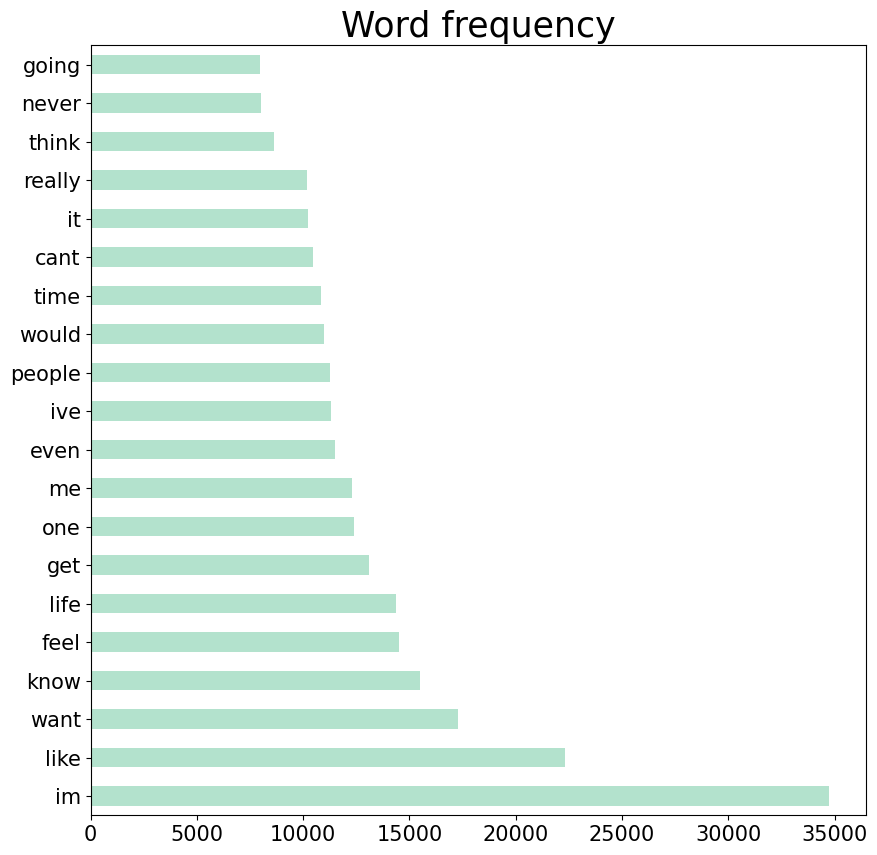

In [12]:
# Visualizing frequency
word_count[:20].plot.barh(figsize=(10,10),
                          fontsize=15,
                          colormap="Pastel2",
                          title="Word frequency").title.set_size(25)


# Split data

## Split into subsets

In [13]:
# Split data into subsets

# Train and Val/Test splits
train_data, val_test_data = train_test_split(dataframe,
                                              test_size=0.3,
                                             shuffle=True, 
                                             random_state=112) 
# Validation and Test splits
val_data, test_data = train_test_split(val_test_data,
                                       test_size=0.5,
                                       random_state=112) # Same seed to avoid mixing the data 

In [14]:
# Amount of data

print(f"""
Total train data: {len(train_data)}\n
Train data (each label):\n {train_data["label"].value_counts()}\n
{"*"*30}
Total validation data: {len(val_data)}\n
Validation data (each label):\n {val_data["label"].value_counts()}\n
{"*"*30}
Total test data: {len(test_data)}\n
Test data (each label):\n {test_data["label"].value_counts()}\n
""")


Total train data: 19583

Train data (each label):
 0    9841
1    9742
Name: label, dtype: int64

******************************
Total validation data: 4197

Validation data (each label):
 0    2172
1    2025
Name: label, dtype: int64

******************************
Total test data: 4197

Test data (each label):
 0    2126
1    2071
Name: label, dtype: int64




## Split into features and labels

In [15]:
# Train splits
train_sentences = train_data["text"].to_list()
train_labels = train_data["label"].to_numpy()

# Val splits
val_sentences = val_data["text"].to_list()
val_labels = val_data["label"].to_numpy()

# Test splits
test_sentences = test_data["text"].to_list()
test_labels = test_data["label"].to_numpy()

In [16]:
print("Train samples:",len(train_sentences), len(train_labels))
print("Val samples:", len(val_sentences), len(val_labels))
print("Test samples:", len(test_sentences), len(test_labels))

Train samples: 19583 19583
Val samples: 4197 4197
Test samples: 4197 4197


# Data visualizations

In [17]:
# Datatypes
type(train_data), type(train_sentences), type(train_labels)

(pandas.core.frame.DataFrame, list, numpy.ndarray)

In [18]:
# Some random samples
for i in range(5):
    rand_index = random.choice(train_data.axes[0])
    print("\nTexto:\n\n",train_data["text"][rand_index])
    print("\nEtiqueta: ",train_data["label"][rand_index])
    print("*"*50)


Texto:

 somy last post  months ago unsure exact date know around  months and last im going unsubbing here maybe ill resub later date im definitely  ill come back help people way people sub helped me much changed generally feel better im sure why something changed know what something has feel slightly better now actually feel okay know im woods yet im getting there know theres plenty obstacles actually looking forward encountering them im starting relish challenge like said idea changed still go work am come home sit room watching tv phone want say thank everyone helped even tried help difficult person help know that ive always thought everything alone real man never asks help wrong matter   matter male female trans idea are matter hard exterior soft need help sometimes cant everything ourselves thats okay now im leaving sub thank again everyone helped least tried appreciate it tldr im feeling better leaving sub

Etiqueta:  1
**************************************************

Texto:


In [19]:
# Random sentence
print("Random sentence:\n\n", random.choice(train_sentences))

Random sentence:

 repost think book ideas want know one interesting rule strong superhumans rule entire cities oppressive caste system built protagonist try live normal life changes run superhuman police changes forever twoman aliens evolved created system earth ecosystems merged created hellscape thousands years passed protagonists meet explore two different worlds mean true meaning humanity antarctic kingdom evolved penguins secret kingdom inside antarctica operated separate humanity millions years however antarctic expedition goes wrong human protagonists see actions race impacted others see scars cant heal ferryman eternal river runs parallel universe links locations universe parallel one used method transportation never ends story follow ferryman travels river exploration fear man vs nature overlay quantum strain man trying fix greatest mistake via time travel accidentally creates bunch time duplicates many causing tear form fabric space time story follows one echoes learning see

In [20]:
# Some labels
train_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

# Baseline

Using MultinomialNB algorithm and tf-idf as vectorizer.

In [21]:
# Scikit-learn pipeline (requires tuples (name, algorithm))
baseline = pipeline.Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("multinomial", MultinomialNB())
])

# Fitting pipeline
baseline.fit(train_sentences, train_labels);

# Checking validation score
print("Baseline accuracy score:")
baseline.score(val_sentences, val_labels)

Baseline accuracy score:


0.8389325708839648

## Results Baseline

In [22]:
# Function to calculate accuracy, precision, recall and f1-score
def calculate_metrics(y_true, y_pred):
    """
    Args:
    ----
    y_pred - Pred labels
    y_true - True labels
    
    Return:
    ----
    Return a dictionary with the model metrics of Accuracy, Precision, Recall and F1-score.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    return {"accuracy":accuracy,
           "precision":precision,
           "f1-score":f1,
           "recall":recall}

In [23]:
# Get predicted labels
baseline_preds = baseline.predict(val_sentences)
baseline_preds[:10]

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [24]:
# Get final results on validation data
baseline_results = calculate_metrics(val_labels, baseline_preds)
baseline_results

{'accuracy': 0.8389325708839648,
 'precision': 0.8711056075714702,
 'f1-score': 0.8363383564006696,
 'recall': 0.8389325708839648}

In [25]:
# As a dataframe
pd.DataFrame(baseline_results, index=["baseline_scores"])

,accuracy,precision,f1-score,recall
baseline_scores,0.838933,0.871106,0.836338,0.838933


# Text vectorizer

## Exploration for vectorizer


In [26]:
# Get a list of our sentences lengths
sentence_len = []
for sentence in train_data["text"]:
    sentence_len.append(len(sentence.split()))
print(sentence_len[:10])

[120, 4, 19, 10, 9, 19, 20, 44, 15, 67]


In [27]:
# Average lengths
int(np.round(np.sum(sentence_len)/len(train_data)))

71

Is this a good representation?

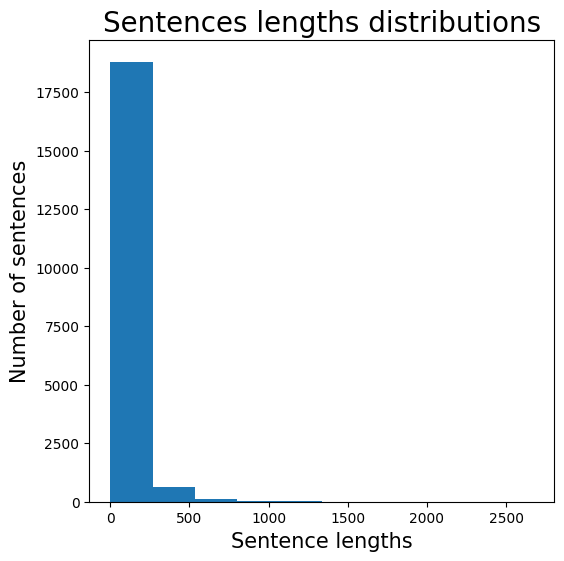

In [28]:
# Checking lengths distributions
plt.figure(figsize=(6,6))
plt.title("Sentences lengths distributions", fontsize=20)
plt.hist(sentence_len, bins=10)
plt.xlabel("Sentence lengths", fontsize=15)
plt.ylabel("Number of sentences", fontsize=15);

The majority of the sentences are between 0 and 500. Let's zoom in.

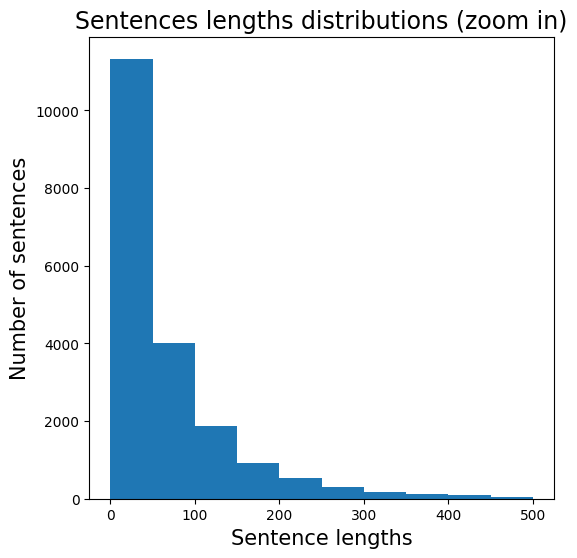

In [29]:
# Zoom in distributions
plt.figure(figsize=(6,6))
plt.title("Sentences lengths distributions (zoom in)", fontsize=17)
plt.hist(sentence_len, bins=10, range=(0, 500))
plt.xlabel("Sentence lengths", fontsize=15)
plt.ylabel("Number of sentences", fontsize=15);

In [30]:
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 99, 100]
percentiles_dict = {}
for percentil in percentiles:
    percentiles_dict[str(percentil) + "th percentil"] = np.percentile(sentence_len, percentil)

In [31]:
pd.DataFrame(percentiles_dict, index=["Percentiles"]).T

,Percentiles
0th percentil,0.00
5th percentil,7.00
10th percentil,9.00
25th percentil,16.00
50th percentil,38.00
75th percentil,87.00
90th percentil,170.00
95th percentil,240.00
99th percentil,472.54
100th percentil,2670.00


I'm going to choose a maximum sentence length value of 80 since 75% of the sentences have a length of 87 or less.

However, we could also try selecting other values, such as 170 or even 240, which would cover most of the sentence lengths.

We can also observe that phrases with a length greater than 500 represent less than 1% of the total, indicating that phrases exceeding thousands are clear outliers.

When we choose a maximum sentence length, what we're doing is filling the sentences that are shorter than that length with zeros, while truncating the sentences that are longer to make them fit. If we were to select the length of the outliers as the maximum value, we would end up with a dataset mostly composed of zeros, as shown below.

In [32]:
# What happens if we take the highest value?
total_words = np.sum(sentence_len)
total_sentences = len(sentence_len)
with_80 = np.multiply(total_sentences, 80)
with_max_len = np.multiply(total_sentences, 2670)

print("Total words:", total_words)
print("Total elements using 80 as maximum length:", with_80)
print("Total elements using the maximum length:", with_max_len)
print(f"Proportion of zeros (max length): {np.divide((with_max_len - total_words), with_max_len) * 100:.3}%")

Total words: 1399621
Total elements using 80 as maximum length: 1566640
Total elements using the maximum length: 52286610
Proportion of zeros (max length): 97.3%


## Creating vectorizer layer


In [81]:
# Vectorizer layer
vocab_size = 10000 # Number of words for our vocabulary
max_sentence_length = 80 # Max sentence length

text_vectorizer = TextVectorization(max_tokens=vocab_size,
                                    output_sequence_length=max_sentence_length)

In [34]:
# Adapting vocabulary to our training sentences
text_vectorizer.adapt(train_sentences)

In [35]:
# Checking the configuration of our vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 10000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 80,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Checking how the vectorizer works

In [36]:
# Checking some words of the vocabulary
vocab = text_vectorizer.get_vocabulary()
print("Top words:", vocab[:10])
print("Last words:", vocab[-10:])

Top words: ['', '[UNK]', 'im', 'like', 'want', 'know', 'feel', 'life', 'get', 'one']
Last words: ['utility', 'usage', 'uptight', 'upgrade', 'upbr', 'unusually', 'unseen', 'unprepared', 'unnoticed', 'unneeded']


In [37]:
# Vectorized sample
random_sentence = random.choice(train_sentences)
vec_sentence = text_vectorizer([random_sentence])

print("Random sentence:\n", random_sentence)
print("\nVectorized sentence:\n", vec_sentence)
print("\nVectorized sentence shape:", vec_sentence.shape)

Random sentence:
 really fg hate covid today day supposed go friends birthday party planned  months ago looked forward it yesterday day party  guess what running high fever still today though much attend party shit  im feeling really really disappointed sad angry irritated sorry vent guys much tell someone

Vectorized sentence:
 tf.Tensor(
[[  17    1   72  964  154   25  421   23   26  538 1000 1214  155  143
   729  586   18  622   25 1000  199  652  802  227 5638   37  154  133
    24 2424 1000   77    2  103   17   17 1103  190  492 6035  187  957
   200   24   97   40    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]], shape=(1, 80), dtype=int64)

Vectorized sentence shape: (1, 80)


After a few visualizations, we can see that all our sentences have the same shape, longer sentences gets truncated to that shape, and smaller sentences get zero padded.

Each word is represented by an unique integer, that represents its index in the vocabulary.

# Word embeddings

In [38]:
# Crreating embedding layer
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=128,
                            name="Embedding_0")

In [39]:
# Visualizing embeddings
embedded_sentence = embedding_layer(vec_sentence) # It takes our vectorizer outputs

print("Embedded sentence:\n\n", embedded_sentence)
print("\nEmbedded sentence shape:\n\n", embedded_sentence.shape)

Embedded sentence:

 tf.Tensor(
[[[ 1.6111467e-02 -1.2339242e-03 -1.0992661e-03 ...  1.1949025e-02
   -2.6286745e-02  1.7531645e-02]
  [ 1.6810298e-03  4.1680422e-02  4.6790455e-02 ...  3.5312299e-02
    4.6146128e-02 -4.7633778e-02]
  [ 7.7533238e-03  6.4004213e-05  2.0110980e-03 ...  2.8203342e-02
    4.4211078e-02 -1.2229431e-02]
  ...
  [-3.4708835e-02  2.8443336e-03 -3.5394132e-02 ... -2.1694792e-02
    2.2824857e-02  4.8392441e-02]
  [-3.4708835e-02  2.8443336e-03 -3.5394132e-02 ... -2.1694792e-02
    2.2824857e-02  4.8392441e-02]
  [-3.4708835e-02  2.8443336e-03 -3.5394132e-02 ... -2.1694792e-02
    2.2824857e-02  4.8392441e-02]]], shape=(1, 80, 128), dtype=float32)

Embedded sentence shape:

 (1, 80, 128)


We recive as output an embedding of shape (1, 100, 128), that is a representation of 128 dim of each word token. 

In other words, each word is represented at the end by a vector composed by 128 decimal values.

These values have been randomly initialized, but as the model trains, it will learn and adjust these values so that it hopefully gets at the end of the training a good representation of the meaning of each word.

# Creating datasets for the models

In [40]:
# Creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels))

In [41]:
# Batching and prefetching
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [42]:
# Amount of batches
len(train_dataset), len(val_dataset), len(test_dataset)

(612, 132, 132)

In [43]:
# Each batch
for sent, labels in train_dataset.take(1):
    print("First sentence in the first batch:\n\n", sent[0])
    print("\nFirst label in the first batch:", labels[0])
    print(f"\nAmount of sentences (per batch): {len(sent)}\nAmount of labels (per batch): {len(labels)}")

First sentence in the first batch:

 tf.Tensor(b'opening night released  tries ambitious production succeeds truly stunning performance gena rowlands character theatre actress myrtle necessarily someone would love real life selfabsorbed often obnoxious makes life miserable around  words unlike actresses myrtle also woman edge collapse  quite sure demons fighting real imagined although let secret early rowlands obviously well directed love gifted husband actordirector john cassavettes role film well film without flaws  overly long last part film myrtle goes stage drunk seems almost cruel improvising dialogue  least stage  goes way long supporting characters give good performances especially ben gazarra playing myrtles sleazy producer joan blondells character never fully developed never could figure film except placate myrtle see film rowlands alone  fascinating throughout  tough take eyes her although want times', shape=(), dtype=string)

First label in the first batch: tf.Tensor(0, sha

# Dense model

In [44]:
# Creating Dense model on Functional API

inputs = Input(shape=(1,), dtype=tf.string) # Input layer
vectorizer = text_vectorizer(inputs) # Vectorizer layer
encoder = embedding_layer(vectorizer) # Embedding layer
dense = Dense(4, activation="relu")(encoder) # Simple Dense layer
flatten = Flatten()(encoder) # Flatten layer
outputs = Dense(1, activation="sigmoid")(flatten) # Dense output layer

model_dense = Model(inputs, outputs) # Putting it together

In [45]:
# Compiling
model_dense.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
# Checking summary
model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 80)               0         
 torization)                                                     
                                                                 
 Embedding_0 (Embedding)     (None, 80, 128)           1280000   
                                                                 
 flatten (Flatten)           (None, 10240)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 10241     
                                                                 
Total params: 1,290,241
Trainable params: 1,290,241
Non-trainable params: 0
___________________________________________________

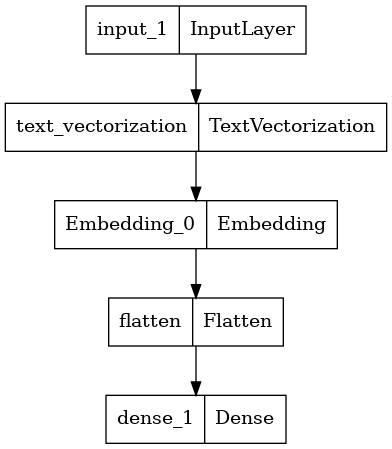

In [46]:
# Plotting model
plot_model(model_dense)

In [47]:
# Training model for 5 epochs
model_dense_history = model_dense.fit(train_dataset,
                                      epochs=5,
                                      validation_data=val_dataset)

Epoch 1/5
612/612 [==============================] - 4s 7ms/step - loss: 0.2942 - accuracy: 0.8765 - val_loss: 0.2080 - val_accuracy: 0.9135
Epoch 2/5
612/612 [==============================] - 4s 7ms/step - loss: 0.1265 - accuracy: 0.9543 - val_loss: 0.2143 - val_accuracy: 0.9111
Epoch 3/5
612/612 [==============================] - 4s 7ms/step - loss: 0.0657 - accuracy: 0.9796 - val_loss: 0.2393 - val_accuracy: 0.9095
Epoch 4/5
612/612 [==============================] - 4s 6ms/step - loss: 0.0325 - accuracy: 0.9914 - val_loss: 0.2670 - val_accuracy: 0.9054
Epoch 5/5
612/612 [==============================] - 4s 7ms/step - loss: 0.0172 - accuracy: 0.9960 - val_loss: 0.2941 - val_accuracy: 0.9045


## Results Dense

In [48]:
def get_model_preds(model, dataset, y_true):
    """
    Recibes a model and a validation or test dataset and return the predictions of the model.
    
    Args:
    ----
    model (Keras Model) - Model used to make predictions.
    dataset (Dataset) - val/test dataset to evaluate the model.
    y_true (array) - True labels to calculate the model results.
    
    Returns:
    --------
    pred_probs (array) - Prediction probabilities of the model on the dataset.
    preds (array) - Predicted labels of the model on the dataset.
    results (dict) - The model results (accuracy, precision, recall, f1-score)
    """
    pred_probs = model.predict(dataset) # Prediction probabilities
    preds = tf.squeeze(tf.round(pred_probs)) # Predicted labels
    results = calculate_metrics(y_true, preds) # Results dictionary
    return pred_probs, preds, results

In [49]:
# Getting our model predictions and results
model_dense_pred_probs, model_dense_preds, dense_results = get_model_preds(model_dense, 
                                                                           val_dataset,
                                                                           val_labels)

132/132 [==============================] - 0s 596us/step


In [50]:
print("Pred probs samples:\n\n", model_dense_pred_probs[:10])
print("\nPred labels samples:\n\n", model_dense_preds[:10])

Pred probs samples:

 [[9.6258980e-01]
 [7.3538263e-07]
 [1.0000000e+00]
 [6.6093293e-05]
 [1.3830549e-03]
 [9.1888416e-01]
 [1.8146748e-02]
 [8.2341779e-05]
 [2.1577219e-02]
 [8.1229860e-01]]

Pred labels samples:

 tf.Tensor([1. 0. 1. 0. 0. 1. 0. 0. 0. 1.], shape=(10,), dtype=float32)


In [51]:
def results_table(names, *args):
    """
    Model results updatable table funcion. Receives model results as arguments
    in dictionary form and returns a dataframe to display and compare them.
    
    Args:
    -----
    model_names (list): List with the names of the models to display in the table (Same amount than *args).
    *args (dict): As many dictionaries of results as models to evaluate (Same amount than model_names).
    """
    results_dict = {}
    for index, arg in enumerate(args):
        results_dict[names[index]] = arg

    return pd.DataFrame(results_dict).T

In [52]:
results_table(["Baseline", "Dense"], baseline_results, dense_results)

,accuracy,precision,f1-score,recall
Baseline,0.838933,0.871106,0.836338,0.838933
Dense,0.904456,0.904545,0.904414,0.904456


# LSTM model

In [53]:
# Crreating custom embedding layer
embedding_lstm = Embedding(input_dim=vocab_size,
                           output_dim=128,
                           name="Embedding_lstm")

# Creating LSTM model on Functional API

inputs = Input(shape=(1,), dtype=tf.string) # Input layer
vectorizer = text_vectorizer(inputs) # Vectorizer layer
encoder = embedding_lstm(vectorizer) # Embedding layer
lstm = LSTM(units=8, activation="relu")(encoder) # LSTM layer
dropout = Dropout(0.2)(lstm)
dense = Dense(4, activation="relu")(dropout)

outputs = Dense(1, activation="sigmoid")(dense) # Dense output layer

model_lstm = Model(inputs, outputs) # Putting it together

In [54]:
# Compiling
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy"])
# Checking summary
model_lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 80)               0         
 torization)                                                     
                                                                 
 Embedding_lstm (Embedding)  (None, 80, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 8)                 4384      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                           

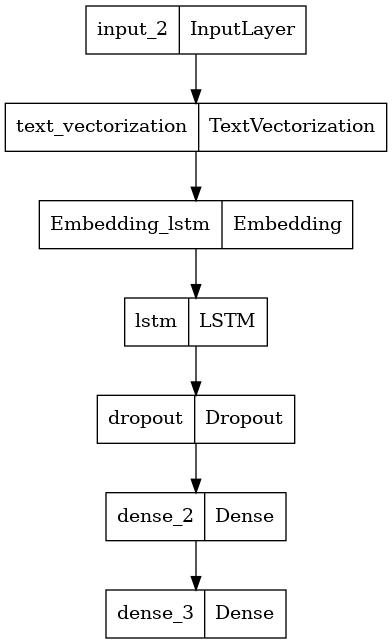

In [55]:
# Plotting model
plot_model(model_lstm)

In [56]:
# Training model for 5 epochs
model_LSTM_history = model_lstm.fit(train_dataset,
                                    epochs=5,
                                    validation_data=val_dataset)

Epoch 1/5
612/612 [==============================] - 9s 14ms/step - loss: 0.6162 - accuracy: 0.7582 - val_loss: 0.3149 - val_accuracy: 0.8835
Epoch 2/5
612/612 [==============================] - 8s 14ms/step - loss: 0.8733 - accuracy: 0.8836 - val_loss: 0.2970 - val_accuracy: 0.8942
Epoch 3/5
612/612 [==============================] - 8s 14ms/step - loss: 0.2496 - accuracy: 0.9072 - val_loss: 0.2856 - val_accuracy: 0.8975
Epoch 4/5
612/612 [==============================] - 8s 14ms/step - loss: 1.3176 - accuracy: 0.9128 - val_loss: 0.2994 - val_accuracy: 0.8856
Epoch 5/5
612/612 [==============================] - 8s 14ms/step - loss: 0.3042 - accuracy: 0.8809 - val_loss: 0.3163 - val_accuracy: 0.8940


## Results LSTM


In [57]:
# Getting our model results
_, lstm_preds, lstm_results = get_model_preds(model_lstm, 
                                      val_dataset,
                                      val_labels)

132/132 [==============================] - 0s 3ms/step


In [58]:
results_table(["Baseline","Dense", "LSTM"], baseline_results, dense_results, lstm_results)

,accuracy,precision,f1-score,recall
Baseline,0.838933,0.871106,0.836338,0.838933
Dense,0.904456,0.904545,0.904414,0.904456
LSTM,0.893972,0.898188,0.893464,0.893972


# Conv1D model

In [59]:
# Custom embedding layer

embedding_conv = Embedding(input_dim=vocab_size,
                            output_dim=128,
                            name="Embedding_conv")

# Creating a convolutional model (Functional API)

inputs = Input(shape=(1,), dtype=tf.string) # Input layer
vectorizer = text_vectorizer(inputs) # Vectorizer layer
encoder = embedding_conv(vectorizer) # Embedding layer
conv_layer = Conv1D(64, 5, 1, padding="same")(encoder) # Convolutional layer
max_pooling = GlobalMaxPooling1D()(conv_layer) # Max Pooling layer
dense = Dense(32, activation="relu")(max_pooling) # Extra Dense layer
outputs = Dense(1, activation="sigmoid")(dense) # Output layer

model_conv = Model(inputs=inputs,
                   outputs=outputs,
                   name="model_Conv1D") # Putting it together

# Compiling 
model_conv.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Tuned learning_rate
                   metrics=["accuracy"])

# Checking summary
model_conv.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 80)               0         
 torization)                                                     
                                                                 
 Embedding_conv (Embedding)  (None, 80, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 80, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 32)               

**Note:** 
I've reduced Adam's learning rate because the model tends to overfit quickly and this way it gets a slight improvement, however if we leave it default it doesn't change much. Even so, the model tends to overfit, but optimizing this is not the goal of this notebook.

The same applies for the extra Dense layer, we can just omit it and doesn't change the result too much.

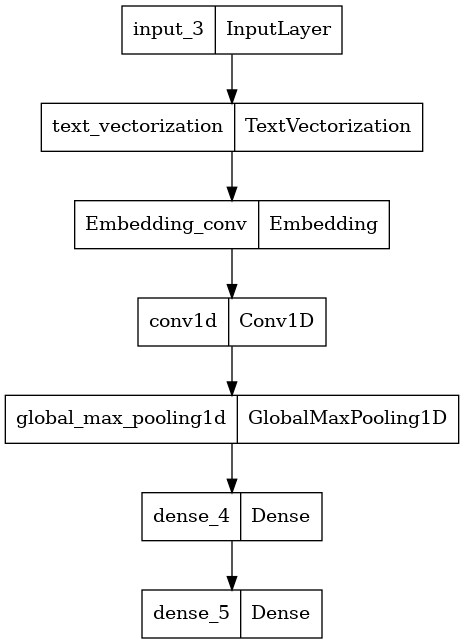

In [60]:
plot_model(model_conv)

In [61]:
model_conv_history = model_conv.fit(train_dataset,
                                        epochs=5,
                                        validation_data=val_dataset)

Epoch 1/5
612/612 [==============================] - 6s 9ms/step - loss: 0.5721 - accuracy: 0.7459 - val_loss: 0.4115 - val_accuracy: 0.8320
Epoch 2/5
612/612 [==============================] - 5s 9ms/step - loss: 0.3176 - accuracy: 0.8754 - val_loss: 0.2804 - val_accuracy: 0.8883
Epoch 3/5
612/612 [==============================] - 6s 9ms/step - loss: 0.2147 - accuracy: 0.9202 - val_loss: 0.2307 - val_accuracy: 0.9128
Epoch 4/5
612/612 [==============================] - 6s 9ms/step - loss: 0.1611 - accuracy: 0.9432 - val_loss: 0.2173 - val_accuracy: 0.9157
Epoch 5/5
612/612 [==============================] - 6s 9ms/step - loss: 0.1260 - accuracy: 0.9581 - val_loss: 0.2146 - val_accuracy: 0.9180


# Results Conv1D

In [62]:
# Get results
_, conv_preds, conv_results = get_model_preds(model_conv, 
                                     val_dataset,
                                     val_labels)

132/132 [==============================] - 0s 1ms/step


In [63]:
final_results = results_table(["Baseline", "Dense", "LSTM", "Conv1D"], baseline_results,
                                                                          dense_results,
                                                                          lstm_results,
                                                                          conv_results)
final_results

,accuracy,precision,f1-score,recall
Baseline,0.838933,0.871106,0.836338,0.838933
Dense,0.904456,0.904545,0.904414,0.904456
LSTM,0.893972,0.898188,0.893464,0.893972
Conv1D,0.918037,0.918034,0.918028,0.918037


# Final visualizations

## Comparing results

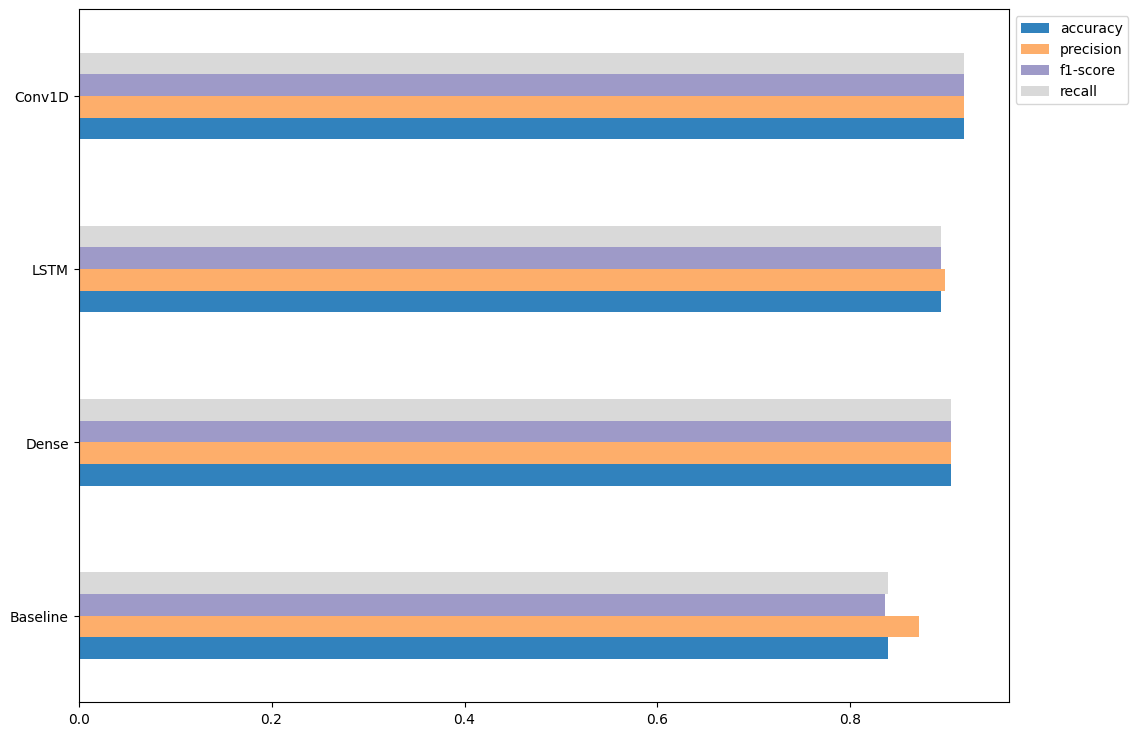

In [64]:
# Plot model results
final_results.plot(kind="barh", figsize=(12,9), cmap="tab20c").legend(bbox_to_anchor=(1.0, 1.0));

## Confusion matrices

In [65]:
def make_cm(y_true, y_pred, title):
    """
    Function to make a simple custom confusion matrix.
    
    Args:
    -----
    y_true (array) - True labels.
    y_pred (array) - Predicted labels.
    title (str) - Title for the confusion matrix
    """
    # Text font
    font = {'family' : 'sans-serif',
    'weight' : 'normal',
    'size'   : 14}
    
    cm = confusion_matrix(y_true, y_pred) # Confusion matrix
    cmp = ConfusionMatrixDisplay(cm) # CM to display
    fig, ax = plt.subplots(figsize=(7,7)) # Fig size
    plt.rc('font', **font) # Font sizes
    cmp.plot(ax=ax, cmap=plt.cm.Blues) # Plot CM
    cmp.ax_.set_title(title, fontsize=24) # Setting title

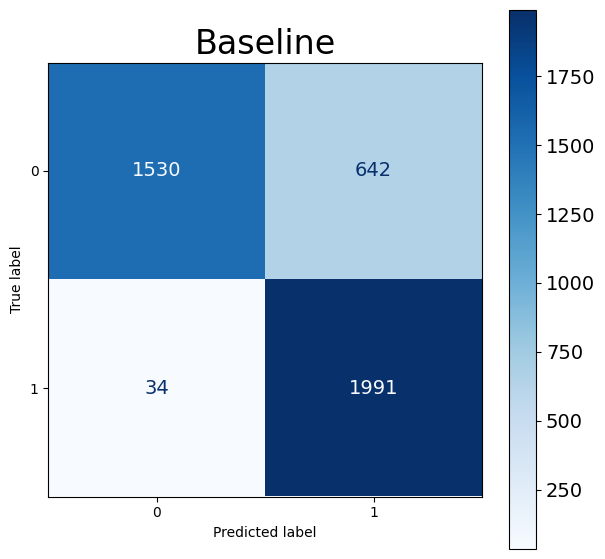

In [66]:
# Baseline CM
make_cm(val_labels, baseline_preds, "Baseline")

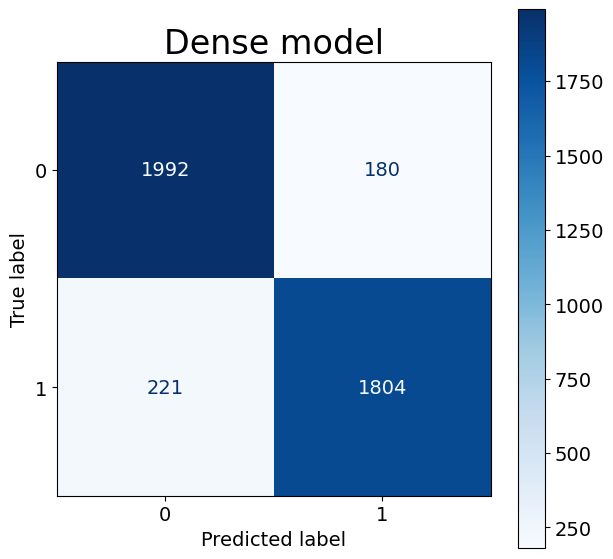

In [67]:
# Dense fully connected CM
make_cm(val_labels, model_dense_preds, "Dense model")

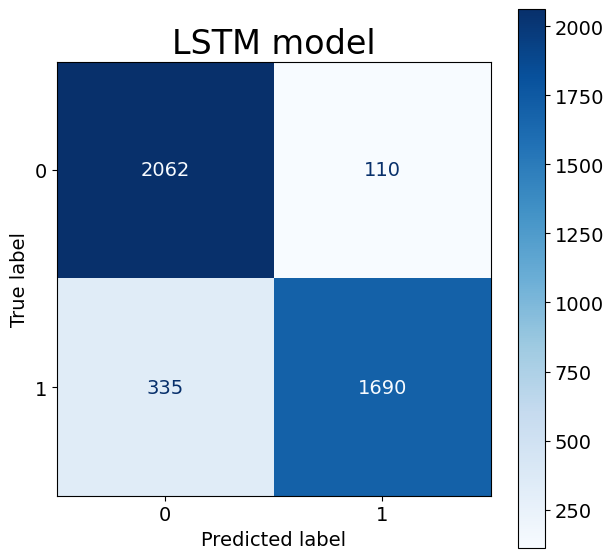

In [68]:
# LSTM CM
make_cm(val_labels, lstm_preds, "LSTM model")

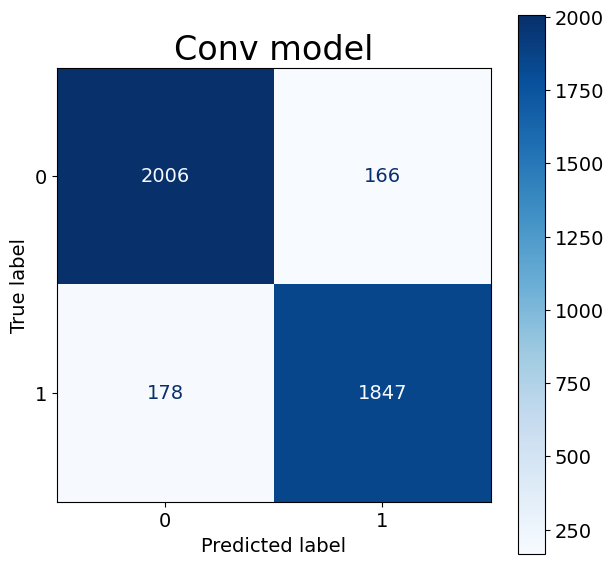

In [69]:
# Conv CM
make_cm(val_labels, conv_preds, "Conv model")

As observed, confusion matrices provide valuable insights into the predictions made by our models.

In this case, the convolutional model appears to be the most balanced, while the baseline model has the highest number of true positives. However, it's evident that the baseline model's ability to predict true positives is influenced by its strong bias. When uncertain, the baseline model tends to classify instances as positives, resulting in a higher number of false positives as well.

Nevertheless, this bias does not necessarily imply a negative aspect. In certain situations, models with such bias can be advantageous. For specific scenarios, we might prefer a model that strictly filters out true negatives. This can be especially useful when the consequence of missing a true negative is severe, such as in critical decision-making processes.

Therefore, it is essential to consider the specific requirements and trade-offs when choosing a model. A balanced model like the convolutional model may be preferable in many cases, but a biased model like the baseline can serve a specific purpose effectively.

# Evaluating model on test set

In [70]:
# Evaluating our best model (model_conv) on test set
test_probs, test_preds, test_results = get_model_preds(model_conv, 
                                                       test_dataset,
                                                       test_labels)
test_results

132/132 [==============================] - 0s 993us/step


{'accuracy': 0.9139861806051942,
 'precision': 0.9142036075470874,
 'f1-score': 0.91395976604108,
 'recall': 0.9139861806051942}

# Worst predictions (test set)

Predictions in which our model have high confidence but it's wrong.

In [71]:
# List with our two possible classes
classes = ["Not considered", "Poisonous"]

In [72]:
# Corresponding predicted classes
pred_classes = [classes[int(pred)] for pred in test_preds.numpy()]

In [73]:
pred_classes[:10], test_preds[:10]

(['Not considered',
  'Not considered',
  'Not considered',
  'Poisonous',
  'Not considered',
  'Not considered',
  'Not considered',
  'Not considered',
  'Poisonous',
  'Not considered'],
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0.], dtype=float32)>)

In [74]:
# Creating dataframe with the predctions
test_data["prediction"] = pred_classes # Column with labels predicted
test_data["probabilities"] = test_probs # Column with probabilities of each label
test_data["correct"] = test_preds == test_data["label"] # Prediction right or not

test_data.head(10)

,text,label,prediction,probabilities,correct
16103,advice attracting opposite sex ask fish fish w...,0,Not considered,0.001072,True
3126,people make hot text posts images videos feel ...,0,Not considered,0.003465,True
22701,brother playing scp secret laboratory rn said ...,0,Not considered,0.005480,True
6277,im fifteen already want dieim tired living spe...,1,Poisonous,0.974158,True
15945,got choccy milks happy meal today feel like k...,0,Not considered,0.013960,True
21266,doctor android use doctors knows apples day do...,0,Not considered,0.026175,True
27863,finland fact sauli niinist alpha male,0,Not considered,0.008212,True
10477,someone family not saying personal reasons thi...,0,Not considered,0.002288,True
27000,wish people would hate end easieri truly belie...,1,Poisonous,0.997818,True
27716,unpopular opinion memes better without meme or...,0,Not considered,0.001973,True


In [75]:
# Sorting samples to get the worst predictions
wrong_samples = test_data[test_data["correct"] == False].sort_values("probabilities", ascending=False)
wrong_samples

,text,label,prediction,probabilities,correct
18192,best way commit redflag guns rope knives,0,Poisonous,0.999692,False
15211,dont want kill hate alive havent really gotten...,0,Poisonous,0.999309,False
8775,normal everytime suicidal thoughts feel happy ...,0,Poisonous,0.998846,False
2657,counts diagnosed depressed clinically depresse...,0,Poisonous,0.998741,False
26023,nothing live fuck living feel like wanna kill ...,0,Poisonous,0.998261,False
...,...,...,...,...,...
3177,im gonna go see one last movie grandparentsthe...,1,Not considered,0.006114,False
22042,im done test,1,Not considered,0.004766,False
22769,wanna diebottom text,1,Not considered,0.004610,False
16323,walking outside wandering area looked around s...,1,Not considered,0.004064,False


Now we can explore the worst predictions as much as we want, getting the sentences individually.

In [76]:
# False positives
worst_false_positives = wrong_samples[wrong_samples["probabilities"] > 0.9]
worst_false_positives

,text,label,prediction,probabilities,correct
18192,best way commit redflag guns rope knives,0,Poisonous,0.999692,False
15211,dont want kill hate alive havent really gotten...,0,Poisonous,0.999309,False
8775,normal everytime suicidal thoughts feel happy ...,0,Poisonous,0.998846,False
2657,counts diagnosed depressed clinically depresse...,0,Poisonous,0.998741,False
26023,nothing live fuck living feel like wanna kill ...,0,Poisonous,0.998261,False
21007,someone talk im lonley suicidal fucked someone...,0,Poisonous,0.998236,False
6564,much karma need post here alt still let post ...,0,Poisonous,0.996835,False
13123,confront mom trigger warning depression self h...,0,Poisonous,0.996099,False
26905,believe months now months since turned back ...,0,Poisonous,0.995828,False
21495,tell parents consider redflag alot tell them i...,0,Poisonous,0.995554,False


In [77]:
# False negatives
worst_false_negatives = wrong_samples[wrong_samples["probabilities"] < 0.1]
worst_false_negatives

,text,label,prediction,probabilities,correct
6059,little success finding one free text therapy apps,1,Not considered,0.098274,False
24180,dont itdont people love,1,Not considered,0.097264,False
26422,good videos selflyingon hope may help others h...,1,Not considered,0.097180,False
4201,ur serious gonna kill urself theres talking le...,1,Not considered,0.092526,False
12731,feel like girl best friend years slowly becom...,1,Not considered,0.087031,False
5500,failed attemptetried drowning ocean got nevk h...,1,Not considered,0.086926,False
27399,academic pressures causing cousin consider red...,1,Not considered,0.082575,False
13190,theres nothing left moves anymore emotions lon...,1,Not considered,0.082519,False
3826,personal article mental health holdback darker...,1,Not considered,0.082515,False
1688,creating final playlistim thinking song or son...,1,Not considered,0.081796,False


In [78]:
# Accessing to sentences (10 worst false positives)
for sentence in worst_false_positives["text"][:10]:
    print("Sentence:\n",sentence, "\n")

Sentence:
 best way commit redflag guns rope knives 

Sentence:
 dont want kill hate alive havent really gotten point want kill myself wouldnt know get around people events still keep wanting end havent enjoyed life idk long 

Sentence:
 normal everytime suicidal thoughts feel happy peace 

Sentence:
 counts diagnosed depressed clinically depressed get regular treatments therapist depressive suicidal thoughts something doctor fills out sort process go through 

Sentence:
 nothing live fuck living feel like wanna kill myself anything live anywayi cant even motivate anything ffs fuck life shit grade im shit anything cant fucking motivate learn anything even though im interested try fucking fail everything live dying efficient im living waste resources thing thats keeping killing courage itand ill glad someone could help itbut fuck would thatjust like failed everything cant even manage kms people fucking except us human beings living rock floating space rock eventually hit another floatin

In [79]:
# Accessing to sentences (10 worst false negatives)
for sentence in worst_false_negatives["text"][-10:]:
    print("Sentence:\n",sentence, "\n")

Sentence:
 whats favorite method finish allwhats method bee thinking whats natural share story facing consequence 

Sentence:
 something like free willi think so make sense 

Sentence:
   great year mask makers acrylic installersbeyond  worst year recall 

Sentence:
 fucking manybeen thinking deleting account might well leave trace theres parallel l saw 

Sentence:
 anyone wanna add snapchat incase need someone at time chat chillas said add chill maybe empty out remove dust vacuum cleaner yknow sc byrnez 

Sentence:
 im gonna go see one last movie grandparentsthe im gonei dare change mind 

Sentence:
 im done test 

Sentence:
 wanna diebottom text 

Sentence:
 walking outside wandering area looked around saw lights car lights traffic lights building lights parking lot lights beautiful know cried seeing them lights 

Sentence:
 hey guys watching seth meyers made joke longest pizza event research june th fontana speedway california mile pizza needs eaten count towards record free event t

# Conclusions and next Steps

Based on our analysis, it appears that the Convolutional model is currently our best performing model. However, it's important to note that this assessment is based on the current set of hyperparameters. Since the training time for these models is not substantial on a GPU, we could further improve the other models by tuning their hyperparameters and evaluating their performance. Additionally, we need to consider the nature of the problem at hand. Depending on the specific requirements, we might need a more precise or higher accuracy model.

Furthermore, it is crucial to consider [multiple metrics](https://neptune.ai/blog/evaluation-metrics-binary-classification#:~:text=What%20exactly%20are%20classification%20metrics,to%20classes%3A%20positive%20and%20negative.) for evaluating the models. Relying solely on accuracy might be inadequate if our dataset is imbalanced. Therefore, it is always advisable to examine various metrics to gain a comprehensive understanding of the models' performance.

We can utilize the insights gained from the visualizations to continue refining our models. There is still room for improvement, and we should explore different techniques such as [model ensembling](https://scikit-learn.org/stable/modules/ensemble.html) or fine-tuning a prebuilt model like the [Universal Sentence Enconder (USE)](https://tfhub.dev/google/universal-sentence-encoder/4). The USE has demonstrated impressive performance in similar tasks such as movie review sentiment analysis or [Amazon review sentiment analysis](https://www.kaggle.com/code/kshitijmohan/sentiment-analysis-universal-sentence-encoder-91).

By leveraging what we have learned and incorporating these approaches, we can continue enhancing our models and striving for even better results.